<a href="https://colab.research.google.com/github/AjaySreekumar47/vlm-research/blob/main/sam%2Bblip2_surgical_instruments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM + BLIP2 Surgical Segmentation Pipeline
# Complete implementation for VLM research

## 1. ENVIRONMENT SETUP AND INSTALLATIONS


In [ ]:
# Install required packages
!pip install segment-anything transformers accelerate torch torchvision
!pip install opencv-python pillow matplotlib seaborn pandas numpy tqdm
!pip install psutil scikit-learn scipy

In [ ]:
# Import all required libraries
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from pathlib import Path
import base64
import io
import zipfile
import tempfile
import os
import time
import psutil
import json
from collections import defaultdict, Counter
from google.colab import drive
import urllib.request
from tqdm import tqdm
import seaborn as sns

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

🖥️ Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


## 2. MOUNT GOOGLE DRIVE AND SETUP PATHS

In [ ]:
# Mount Google Drive
print("📂 Mounting Google Drive...")
drive.mount('/content/drive')

# Set up data paths
DRIVE_PATH = '/content/drive/MyDrive/'
ENDOVIS_ZIP_PATH = '/content/drive/MyDrive/Endo2017/instrument_1_4_training.zip'

print(f"📦 Looking for surgical data at: {ENDOVIS_ZIP_PATH}")
if os.path.exists(ENDOVIS_ZIP_PATH):
    print("✅ EndoVis data found!")
else:
    print("❌ EndoVis data not found. Please check the path.")

📂 Mounting Google Drive...
Mounted at /content/drive
📦 Looking for surgical data at: /content/drive/MyDrive/Endo2017/instrument_1_4_training.zip
✅ EndoVis data found!


## 3. DOWNLOAD AND SETUP SAM

In [ ]:
print("🔧 Setting up SAM...")

# Create checkpoints directory
os.makedirs('/content/sam_checkpoints', exist_ok=True)

# Download SAM checkpoint (ViT-B version for memory efficiency)
sam_checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
sam_checkpoint_path = "/content/sam_checkpoints/sam_vit_b_01ec64.pth"

if not os.path.exists(sam_checkpoint_path):
    print("📥 Downloading SAM checkpoint... (358MB)")
    urllib.request.urlretrieve(sam_checkpoint_url, sam_checkpoint_path)
    print("✅ SAM checkpoint downloaded!")
else:
    print("✅ SAM checkpoint already exists")

# Setup SAM
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_path)
sam.to(device)
sam_predictor = SamPredictor(sam)
print("✅ SAM loaded successfully!")

🔧 Setting up SAM...
📥 Downloading SAM checkpoint... (358MB)
✅ SAM checkpoint downloaded!
✅ SAM loaded successfully!


## 4. SETUP BLIP2

In [ ]:
print("🔧 Setting up BLIP2...")

from transformers import Blip2Processor, Blip2ForConditionalGeneration

# Load BLIP2 model (using smaller version for Colab compatibility)
blip2_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,  # Use half precision for memory efficiency
    device_map="auto"
)

print("✅ BLIP2 loaded successfully!")

🔧 Setting up BLIP2...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

✅ BLIP2 loaded successfully!


## 5. DATA LOADING FROM ZIP FILE

In [ ]:
def load_endovis_from_zip(zip_path=ENDOVIS_ZIP_PATH):
    """Load EndoVis2017 surgical data directly from zip file"""
    print(f"📦 Loading surgical data from ZIP: {zip_path}")

    if not os.path.exists(zip_path):
        print(f"❌ ZIP file not found: {zip_path}")
        return []

    surgical_images = []

    # Open zip file and explore structure
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("🔍 Exploring ZIP file structure...")

        # List all files in zip
        all_files = zip_ref.namelist()

        # Find surgical image sequences
        instrument_datasets = set()
        for file_path in all_files:
            if 'instrument_dataset_' in file_path and 'left_frames' in file_path and file_path.endswith('.png'):
                # Extract dataset number
                parts = file_path.split('/')
                for part in parts:
                    if 'instrument_dataset_' in part:
                        instrument_datasets.add(part)
                        break

        print(f"✅ Found {len(instrument_datasets)} instrument datasets: {sorted(instrument_datasets)}")

        # For each dataset, collect first 3 images for testing
        for dataset in sorted(instrument_datasets):
            dataset_images = []
            for file_path in all_files:
                if dataset in file_path and 'left_frames' in file_path and file_path.endswith('.png'):
                    dataset_images.append(file_path)

            # Sort and take first 3 images
            dataset_images.sort()
            for img_path in dataset_images[:3]:  # Limit to 3 per dataset for testing
                surgical_images.append({
                    'zip_path': img_path,
                    'dataset': dataset,
                    'frame': Path(img_path).stem,
                    'zip_file': zip_path
                })

        print(f"📊 Selected {len(surgical_images)} surgical images for analysis")

        # Display sample structure
        if surgical_images:
            print(f"\n📋 Sample image paths:")
            for i, img_info in enumerate(surgical_images[:3]):
                print(f"   {i+1}. {img_info['zip_path']}")

    return surgical_images

def load_surgical_image_from_zip(zip_file_path, internal_path):
    """Load surgical image directly from zip file"""
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Read image data from zip
            with zip_ref.open(internal_path) as file:
                image_data = file.read()

            # Convert to numpy array
            nparr = np.frombuffer(image_data, np.uint8)
            image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            if image is None:
                print(f"❌ Could not decode image: {internal_path}")
                return None

            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            return image

    except Exception as e:
        print(f"❌ Error loading image from zip: {e}")
        return None

# Load surgical data
surgical_data = load_endovis_from_zip()
print(f"🎯 Ready to process {len(surgical_data)} surgical images")

📦 Loading surgical data from ZIP: /content/drive/MyDrive/Endo2017/instrument_1_4_training.zip
🔍 Exploring ZIP file structure...
✅ Found 4 instrument datasets: ['instrument_dataset_1', 'instrument_dataset_2', 'instrument_dataset_3', 'instrument_dataset_4']
📊 Selected 12 surgical images for analysis

📋 Sample image paths:
   1. instrument_dataset_1/left_frames/frame000.png
   2. instrument_dataset_1/left_frames/frame001.png
   3. instrument_dataset_1/left_frames/frame002.png
🎯 Ready to process 12 surgical images


## 6. GROUND TRUTH LOADING FOR EVALUATION

In [ ]:
def load_endovis_ground_truth(image_info):
    """Load corresponding ground truth mask for EndoVis image"""

    # Extract sequence and frame info
    dataset = image_info['dataset']
    frame = image_info['frame']
    zip_file = image_info['zip_file']

    # Look for ground truth masks in the zip
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            ground_truth_masks = []
            instrument_types = []

            # Find all instrument masks for this frame
            frame_number = frame.replace('frame', '').lstrip('0') or '0'

            for file_path in zip_ref.namelist():
                if ('ground_truth' in file_path and
                    frame_number in file_path and
                    file_path.endswith('.png')):

                    try:
                        # Load mask
                        with zip_ref.open(file_path) as file:
                            mask_data = file.read()
                            nparr = np.frombuffer(mask_data, np.uint8)
                            mask = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

                            if mask is not None:
                                ground_truth_masks.append(mask)
                                # Extract instrument type from path
                                path_parts = file_path.split('/')
                                instrument_type = 'surgical_instrument'  # Default
                                for part in path_parts:
                                    if any(term in part.lower() for term in ['grasper', 'scissors', 'needle', 'forceps', 'clip']):
                                        instrument_type = part
                                        break
                                instrument_types.append(instrument_type)
                    except Exception as e:
                        continue

            # Create combined mask or default
            if ground_truth_masks:
                combined_mask = np.zeros_like(ground_truth_masks[0])
                for mask in ground_truth_masks:
                    combined_mask = np.logical_or(combined_mask, mask > 0).astype(np.uint8)

                return {
                    'combined_mask': combined_mask,
                    'individual_masks': ground_truth_masks,
                    'instrument_types': instrument_types if instrument_types else ['surgical_instrument']
                }
            else:
                # Create dummy ground truth if none found
                dummy_mask = np.zeros((480, 640), dtype=np.uint8)  # Default size
                return {
                    'combined_mask': dummy_mask,
                    'individual_masks': [dummy_mask],
                    'instrument_types': ['surgical_instrument']
                }

    except Exception as e:
        # Return dummy data
        dummy_mask = np.zeros((480, 640), dtype=np.uint8)
        return {
            'combined_mask': dummy_mask,
            'individual_masks': [dummy_mask],
            'instrument_types': ['surgical_instrument']
        }

## 7. BLIP2 SURGICAL ANALYSIS FUNCTIONS

In [ ]:
def extract_surgical_terms(caption):
    """Extract surgical instrument terms from caption"""
    surgical_vocabulary = [
        'grasper', 'forceps', 'scissors', 'needle', 'holder', 'clamp',
        'scalpel', 'probe', 'retractor', 'cautery', 'suture', 'clip',
        'instrument', 'surgical', 'medical', 'tool', 'device', 'surgery',
        'endoscopic', 'laparoscopic', 'robotic'
    ]

    found_terms = []
    caption_lower = caption.lower()

    for term in surgical_vocabulary:
        if term in caption_lower:
            found_terms.append(term)

    return found_terms

def blip2_surgical_analysis(image):
    """Enhanced surgical analysis with BLIP2"""
    # Convert numpy to PIL
    pil_image = Image.fromarray(image)

    # Multiple surgical-focused prompts
    surgical_prompts = [
        "a medical image of",
        "this surgical image shows",
        "the surgical instruments are",
        "in this operating room image",
        "the surgical procedure involves"
    ]

    blip2_results = {}

    for prompt in surgical_prompts:
        # Process with BLIP2
        inputs = blip2_processor(pil_image, prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            generated_ids = blip2_model.generate(
                **inputs,
                max_length=50,
                num_beams=5,
                do_sample=False,
                repetition_penalty=1.1,
                length_penalty=1.0
            )

        caption = blip2_processor.decode(generated_ids[0], skip_special_tokens=True)
        blip2_results[prompt] = caption
        print(f"    '{prompt}' → {caption}")

    # Find the most informative caption
    best_caption = max(blip2_results.values(), key=len)
    blip2_results['best_caption'] = best_caption
    blip2_results['surgical_terms'] = extract_surgical_terms(best_caption)

    return blip2_results

## 8. SAM SEGMENTATION FUNCTIONS

In [ ]:
def generate_surgical_points(image, blip2_results):
    """Generate strategic points for surgical instrument segmentation"""
    h, w = image.shape[:2]

    # Common locations for surgical instruments in endoscopic views
    strategic_points = [
        [w//4, h//3],      # Upper left quadrant
        [3*w//4, h//3],    # Upper right quadrant
        [w//2, 2*h//3],    # Lower center
        [w//4, 2*h//3],    # Lower left
        [3*w//4, 2*h//3],  # Lower right
    ]

    # Filter based on BLIP2 understanding
    surgical_terms = blip2_results.get('surgical_terms', [])

    if 'instrument' in surgical_terms or 'surgical' in surgical_terms:
        # Use all strategic points
        return strategic_points
    else:
        # Use fewer points if no clear surgical content detected
        return strategic_points[:3]

def sam_surgical_segmentation(image, blip2_results, custom_prompts=None):
    """Use SAM to segment based on BLIP2 understanding"""
    sam_predictor.set_image(image)

    sam_results = {
        'masks': [],
        'scores': [],
        'prompts_used': [],
        'segmentation_points': []
    }

    # Strategy 1: Center point (baseline)
    h, w = image.shape[:2]
    center_point = np.array([[w//2, h//2]])

    masks, scores, logits = sam_predictor.predict(
        point_coords=center_point,
        point_labels=np.array([1]),
        multimask_output=True,
    )

    sam_results['masks'].extend(masks)
    sam_results['scores'].extend(scores)
    sam_results['prompts_used'].extend(['center_point'] * len(masks))
    sam_results['segmentation_points'].append(center_point)

    # Strategy 2: Multiple strategic points for surgical instruments
    strategic_points = generate_surgical_points(image, blip2_results)

    for i, point in enumerate(strategic_points):
        masks, scores, logits = sam_predictor.predict(
            point_coords=np.array([point]),
            point_labels=np.array([1]),
            multimask_output=True,
        )

        sam_results['masks'].extend(masks)
        sam_results['scores'].extend(scores)
        sam_results['prompts_used'].extend([f'strategic_point_{i}'] * len(masks))
        sam_results['segmentation_points'].append(np.array([point]))

    return sam_results

def combine_blip2_sam_results(blip2_results, sam_results):
    """Combine BLIP2 understanding with SAM segmentation"""
    combined = {
        'surgical_understanding': blip2_results['best_caption'],
        'instruments_detected': blip2_results['surgical_terms'],
        'best_masks': [],
        'confidence_scores': []
    }

    # Select best masks based on scores
    mask_score_pairs = list(zip(sam_results['masks'], sam_results['scores']))
    mask_score_pairs.sort(key=lambda x: x[1], reverse=True)  # Sort by score

    # Take top 3 masks
    for mask, score in mask_score_pairs[:3]:
        combined['best_masks'].append(mask)
        combined['confidence_scores'].append(score)

    return combined

## 9. COMPLETE SAM + BLIP2 PIPELINE

In [ ]:
def surgical_sam_blip2_pipeline_zip(image_info, surgical_prompts=None):
    """Complete SAM + BLIP2 pipeline for surgical images from ZIP"""
    print(f"🔬 Processing surgical image with BLIP2: {image_info['dataset']} - {image_info['frame']}")

    # Load image from ZIP
    image = load_surgical_image_from_zip(image_info['zip_file'], image_info['zip_path'])
    if image is None:
        return None

    results = {
        'image_info': image_info,
        'image': image,
        'blip2_analysis': {},
        'sam_segmentation': {},
        'combined_results': {}
    }

    # Step 1: BLIP2 Understanding
    print("  📝 BLIP2 Analysis...")
    blip2_results = blip2_surgical_analysis(image)
    results['blip2_analysis'] = blip2_results

    # Step 2: SAM Segmentation
    print("  ✂️ SAM Segmentation...")
    sam_results = sam_surgical_segmentation(image, blip2_results, surgical_prompts)
    results['sam_segmentation'] = sam_results

    # Step 3: Combined Analysis
    print("  🔗 Combined Analysis...")
    combined_results = combine_blip2_sam_results(blip2_results, sam_results)
    results['combined_results'] = combined_results

    return results

## 10. METRICS CALCULATION FUNCTIONS

In [ ]:
def get_boundary_points(binary_mask):
    """Extract boundary points from binary mask"""
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundary_points = []
    for contour in contours:
        boundary_points.extend(contour.reshape(-1, 2))
    return np.array(boundary_points) if boundary_points else np.array([])

def calculate_segmentation_metrics(predicted_mask, ground_truth_mask):
    """Calculate comprehensive segmentation metrics"""

    # Ensure binary masks
    pred_binary = (predicted_mask > 0.5).astype(float)
    gt_binary = (ground_truth_mask > 0.5).astype(float)

    # Core segmentation metrics
    intersection = (pred_binary * gt_binary).sum()
    union = pred_binary.sum() + gt_binary.sum() - intersection

    # 1. Dice Score (F1 for segmentation)
    dice = (2 * intersection) / (pred_binary.sum() + gt_binary.sum()) if (pred_binary.sum() + gt_binary.sum()) > 0 else 0

    # 2. IoU (Jaccard Index)
    iou = intersection / union if union > 0 else 0

    # 3. Pixel Accuracy
    pixel_accuracy = ((pred_binary == gt_binary).sum()) / gt_binary.size

    # 4. Precision & Recall
    true_positives = intersection
    false_positives = pred_binary.sum() - intersection
    false_negatives = gt_binary.sum() - intersection

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # 5. Specificity (True Negative Rate)
    true_negatives = gt_binary.size - (true_positives + false_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0

    # 6. Hausdorff Distance (boundary accuracy)
    try:
        from scipy.spatial.distance import directed_hausdorff
        pred_boundary = get_boundary_points(pred_binary)
        gt_boundary = get_boundary_points(gt_binary)
        if len(pred_boundary) > 0 and len(gt_boundary) > 0:
            hausdorff_dist = max(directed_hausdorff(pred_boundary, gt_boundary)[0],
                               directed_hausdorff(gt_boundary, pred_boundary)[0])
        else:
            hausdorff_dist = float('inf')
    except:
        hausdorff_dist = None

    return {
        'dice_score': dice,
        'iou_score': iou,
        'pixel_accuracy': pixel_accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0,
        'hausdorff_distance': hausdorff_dist
    }

def calculate_vlm_metrics(blip2_results, ground_truth_instruments):
    """Calculate vision-language understanding metrics"""

    detected_terms = blip2_results['surgical_terms']

    # 1. Surgical Term Detection Accuracy
    true_instruments = set(ground_truth_instruments.lower().split())
    detected_instruments = set(detected_terms)

    # Term-level precision/recall
    correct_detections = true_instruments.intersection(detected_instruments)
    term_precision = len(correct_detections) / len(detected_instruments) if detected_instruments else 0
    term_recall = len(correct_detections) / len(true_instruments) if true_instruments else 0
    term_f1 = 2 * (term_precision * term_recall) / (term_precision + term_recall) if (term_precision + term_recall) > 0 else 0

    # 2. Caption Quality Metrics
    best_caption = blip2_results['best_caption']

    # Caption length and informativeness
    caption_length = len(best_caption.split())
    surgical_vocab_coverage = len(detected_terms) / len(true_instruments) if true_instruments else 0

    # 3. Caption Consistency
    caption_values = []
    for key, value in blip2_results.items():
        if key not in ['surgical_terms', 'best_caption'] and isinstance(value, str):
            caption_values.append(value)

    caption_consistency = len(set(caption_values)) / len(caption_values) if caption_values else 1

    return {
        'term_precision': term_precision,
        'term_recall': term_recall,
        'term_f1_score': term_f1,
        'surgical_terms_detected': len(detected_terms),
        'surgical_terms_expected': len(true_instruments),
        'caption_length': caption_length,
        'vocabulary_coverage': surgical_vocab_coverage,
        'caption_consistency': caption_consistency,
        'detected_instruments': list(detected_instruments),
        'expected_instruments': list(true_instruments)
    }

def calculate_performance_metrics(pipeline_function, image_info, **kwargs):
    """Calculate performance and efficiency metrics"""

    # Memory usage before
    memory_before = psutil.Process().memory_info().rss / 1024 / 1024  # MB
    gpu_memory_before = torch.cuda.memory_allocated() / 1024 / 1024 if torch.cuda.is_available() else 0

    # Time the pipeline
    start_time = time.time()
    results = pipeline_function(image_info, **kwargs)
    end_time = time.time()

    # Memory usage after
    memory_after = psutil.Process().memory_info().rss / 1024 / 1024  # MB
    gpu_memory_after = torch.cuda.memory_allocated() / 1024 / 1024 if torch.cuda.is_available() else 0

    return {
        'inference_time': end_time - start_time,
        'memory_usage_mb': memory_after - memory_before,
        'gpu_memory_usage_mb': gpu_memory_after - gpu_memory_before,
        'fps': 1 / (end_time - start_time),
        'results': results
    }

## 11. VISUALIZATION FUNCTIONS

In [ ]:
def visualize_sam_blip2_results(results):
    """Visualize complete SAM+BLIP2 pipeline results"""
    if results is None:
        print("❌ No results to visualize")
        return

    image = results['image']
    image_info = results['image_info']
    blip2_analysis = results['blip2_analysis']
    combined_results = results['combined_results']

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Row 1: Original image and BLIP2 understanding
    axes[0, 0].imshow(image)
    title = f"Surgical Image\n{image_info['dataset']}\n{image_info['frame']}"
    axes[0, 0].set_title(title, fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    # BLIP2 analysis text
    blip2_text = f"BLIP2 Understanding:\n{blip2_analysis['best_caption']}\n\nSurgical Terms Found:\n{', '.join(blip2_analysis['surgical_terms']) if blip2_analysis['surgical_terms'] else 'None detected'}"
    axes[0, 1].text(0.1, 0.5, blip2_text, transform=axes[0, 1].transAxes,
                   fontsize=10, verticalalignment='center', wrap=True)
    axes[0, 1].set_title("BLIP2 Surgical Analysis", fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    # Combined understanding
    confidence_scores = combined_results['confidence_scores']
    max_conf = max(confidence_scores) if confidence_scores else 0
    combined_text = f"Combined Analysis:\n\nDetected: {combined_results['surgical_understanding']}\n\nInstruments: {combined_results['instruments_detected']}\n\nTop Confidence: {max_conf:.3f}\n\nTotal Masks: {len(combined_results['best_masks'])}"
    axes[0, 2].text(0.1, 0.5, combined_text, transform=axes[0, 2].transAxes,
                   fontsize=10, verticalalignment='center', wrap=True)
    axes[0, 2].set_title("Combined BLIP2+SAM Analysis", fontsize=14, fontweight='bold')
    axes[0, 2].axis('off')

    # Row 2: SAM segmentation results
    best_masks = combined_results['best_masks']
    confidence_scores = combined_results['confidence_scores']

    for i in range(3):
        if i < len(best_masks):
            axes[1, i].imshow(image)
            axes[1, i].imshow(best_masks[i], alpha=0.5, cmap='viridis')
            axes[1, i].set_title(f"SAM Mask {i+1}\nScore: {confidence_scores[i]:.3f}",
                                fontsize=12, fontweight='bold')
        else:
            axes[1, i].text(0.5, 0.5, "No Additional\nMask", transform=axes[1, i].transAxes,
                           ha='center', va='center', fontsize=14)
            axes[1, i].set_title(f"SAM Mask {i+1}", fontsize=12, fontweight='bold')

        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed summary
    print(f"\n📊 Detailed Results for {image_info['dataset']} - {image_info['frame']}:")
    print(f"   🔍 BLIP2 Terms: {blip2_analysis['surgical_terms']}")
    print(f"   ✂️ SAM Masks: {len(combined_results['best_masks'])}")
    print(f"   🎯 Confidence: {max_conf:.3f}")
    print(f"   📋 Understanding: {combined_results['surgical_understanding'][:100]}...")

## 12. COMPREHENSIVE EVALUATION PIPELINE

In [ ]:
def evaluate_sam_blip2_performance(surgical_data, num_samples=8):
    """Comprehensive evaluation of SAM+BLIP2 performance"""

    print("🔬 Comprehensive SAM+BLIP2 Performance Evaluation")
    print("=" * 60)

    all_metrics = {
        'segmentation': [],
        'vlm_understanding': [],
        'performance': [],
        'per_image_results': []
    }

    successful_evaluations = 0

    for i in range(min(num_samples, len(surgical_data))):
        image_info = surgical_data[i]
        print(f"\n📷 Evaluating Image {i+1}: {image_info['dataset']} - {image_info['frame']}")

        try:
            # Load ground truth
            gt_data = load_endovis_ground_truth(image_info)

            # Run SAM+BLIP2 pipeline with performance monitoring
            perf_metrics = calculate_performance_metrics(
                surgical_sam_blip2_pipeline_zip,
                image_info
            )

            results = perf_metrics['results']

            if results and results['combined_results']['best_masks']:
                # 1. Segmentation metrics
                best_mask = results['combined_results']['best_masks'][0]
                seg_metrics = calculate_segmentation_metrics(best_mask, gt_data['combined_mask'])

                # 2. VLM metrics
                instrument_string = ' '.join(gt_data['instrument_types'])
                vlm_metrics = calculate_vlm_metrics(results['blip2_analysis'], instrument_string)

                # 3. Performance metrics
                performance_metrics = {
                    'inference_time': perf_metrics['inference_time'],
                    'memory_usage_mb': perf_metrics.get('memory_usage_mb', 0),
                    'gpu_memory_usage_mb': perf_metrics.get('gpu_memory_usage_mb', 0)
                }

                # Store results
                all_metrics['segmentation'].append(seg_metrics)
                all_metrics['vlm_understanding'].append(vlm_metrics)
                all_metrics['performance'].append(performance_metrics)

                all_metrics['per_image_results'].append({
                    'image_info': image_info,
                    'segmentation': seg_metrics,
                    'vlm': vlm_metrics,
                    'performance': performance_metrics
                })

                successful_evaluations += 1

                print(f"   ✅ Dice: {seg_metrics['dice_score']:.3f}, IoU: {seg_metrics['iou_score']:.3f}")
                print(f"   🔍 Term F1: {vlm_metrics['term_f1_score']:.3f}, Time: {performance_metrics['inference_time']:.2f}s")
                print(f"   📝 Detected: {vlm_metrics['detected_instruments']}")

            else:
                print(f"   ❌ Pipeline failed - no masks generated")

        except Exception as e:
            print(f"   ❌ Evaluation failed: {e}")
            continue

    print(f"\n📊 Successfully evaluated {successful_evaluations}/{num_samples} images")

    if successful_evaluations > 0:
        # Calculate aggregate statistics
        aggregate_metrics = calculate_aggregate_metrics(all_metrics)

        # Display comprehensive results
        display_performance_report(aggregate_metrics, all_metrics)

        return all_metrics, aggregate_metrics
    else:
        print("❌ No successful evaluations")
        return None, None

def calculate_aggregate_metrics(all_metrics):
    """Calculate aggregate statistics"""
    if not all_metrics['segmentation']:
        return None

    seg_metrics = all_metrics['segmentation']
    vlm_metrics = all_metrics['vlm_understanding']
    perf_metrics = all_metrics['performance']

    return {
        'segmentation': {
            'mean_dice': np.mean([m['dice_score'] for m in seg_metrics]),
            'std_dice': np.std([m['dice_score'] for m in seg_metrics]),
            'mean_iou': np.mean([m['iou_score'] for m in seg_metrics]),
            'std_iou': np.std([m['iou_score'] for m in seg_metrics]),
            'mean_precision': np.mean([m['precision'] for m in seg_metrics]),
            'mean_recall': np.mean([m['recall'] for m in seg_metrics])
        },
        'vlm': {
            'mean_term_f1': np.mean([m['term_f1_score'] for m in vlm_metrics]),
            'mean_term_precision': np.mean([m['term_precision'] for m in vlm_metrics]),
            'mean_term_recall': np.mean([m['term_recall'] for m in vlm_metrics]),
            'total_terms_detected': sum([m['surgical_terms_detected'] for m in vlm_metrics])
        },
        'performance': {
            'mean_inference_time': np.mean([m['inference_time'] for m in perf_metrics]),
            'mean_memory_usage': np.mean([m['memory_usage_mb'] for m in perf_metrics]),
            'mean_fps': 1 / np.mean([m['inference_time'] for m in perf_metrics])
        }
    }

def display_performance_report(aggregate_metrics, all_metrics):
    """Display comprehensive performance report"""
    print(f"\n" + "=" * 60)
    print("📊 SAM+BLIP2 PERFORMANCE REPORT")
    print("=" * 60)

    if aggregate_metrics is None:
        print("❌ No metrics to display")
        return

    # Segmentation Performance
    seg = aggregate_metrics['segmentation']
    print(f"\n🎯 SEGMENTATION PERFORMANCE:")
    print(f"   Dice Score:    {seg['mean_dice']:.3f} ± {seg['std_dice']:.3f}")
    print(f"   IoU Score:     {seg['mean_iou']:.3f} ± {seg['std_iou']:.3f}")
    print(f"   Precision:     {seg['mean_precision']:.3f}")
    print(f"   Recall:        {seg['mean_recall']:.3f}")

    # VLM Performance
    vlm = aggregate_metrics['vlm']
    print(f"\n🔍 VISION-LANGUAGE PERFORMANCE:")
    print(f"   Term F1:       {vlm['mean_term_f1']:.3f}")
    print(f"   Term Precision: {vlm['mean_term_precision']:.3f}")
    print(f"   Term Recall:   {vlm['mean_term_recall']:.3f}")
    print(f"   Terms Detected: {vlm['total_terms_detected']}")

    # Performance Metrics
    perf = aggregate_metrics['performance']
    print(f"\n⚡ SYSTEM PERFORMANCE:")
    print(f"   Inference Time: {perf['mean_inference_time']:.2f}s")
    print(f"   Memory Usage:  {perf['mean_memory_usage']:.1f} MB")
    print(f"   FPS:           {perf['mean_fps']:.1f}")

    print(f"\n📈 OVERALL ASSESSMENT:")
    if seg['mean_dice'] > 0.8:
        print(f"   🏆 Excellent segmentation performance!")
    elif seg['mean_dice'] > 0.6:
        print(f"   👍 Good segmentation performance")
    else:
        print(f"   ⚠️  Segmentation needs improvement")

    if vlm['mean_term_f1'] > 0.7:
        print(f"   🏆 Excellent surgical understanding!")
    elif vlm['mean_term_f1'] > 0.5:
        print(f"   👍 Good surgical understanding")
    else:
        print(f"   ⚠️  Understanding needs improvement")

## 13. BATCH PROCESSING AND COMPARISON FUNCTIONS

In [ ]:
def batch_sam_blip2_analysis(surgical_data, num_samples=6):
    """Run SAM+BLIP2 pipeline on multiple surgical images"""
    print(f"🔬 Running SAM+BLIP2 Pipeline on {num_samples} Surgical Images")
    print("=" * 70)

    all_results = []

    for i in range(min(num_samples, len(surgical_data))):
        surgical_image = surgical_data[i]
        print(f"\n📷 Processing Image {i+1}: {surgical_image['dataset']} - {surgical_image['frame']}")
        print("-" * 60)

        # Run pipeline
        results = surgical_sam_blip2_pipeline_zip(surgical_image)

        if results:
            # Visualize results
            visualize_sam_blip2_results(results)
            all_results.append(results)
            print(f"✅ Successfully processed image {i+1}")
        else:
            print(f"❌ Failed to process image {i+1}")

    return all_results

def save_results_for_comparison(results, model_name="SAM_BLIP2"):
    """Save results for later comparison with other approaches"""
    if results:
        # Prepare results for JSON serialization
        serializable_results = []
        for result in results:
            serializable_result = {
                'model': model_name,
                'image_info': result['image_info'],
                'blip2_analysis': {
                    'best_caption': result['blip2_analysis']['best_caption'],
                    'surgical_terms': result['blip2_analysis']['surgical_terms']
                },
                'combined_results': {
                    'surgical_understanding': result['combined_results']['surgical_understanding'],
                    'instruments_detected': result['combined_results']['instruments_detected'],
                    'num_masks': len(result['combined_results']['best_masks']),
                    'confidence_scores': [float(score) for score in result['combined_results']['confidence_scores']]
                }
            }
            serializable_results.append(serializable_result)

        # Save to file
        save_path = f"/content/{model_name.lower()}_results.json"
        with open(save_path, 'w') as f:
            json.dump(serializable_results, f, indent=2)

        print(f"💾 {model_name} results saved to: {save_path}")
        return save_path

    return None

#==============================================================================
# 14. COMPARISON WITH PREVIOUS RESULTS
#==============================================================================

def compare_with_baseline(blip2_metrics, baseline_results_path=None):
    """Compare BLIP2 results with baseline (if available)"""
    print(f"\n📊 COMPARISON ANALYSIS")
    print("=" * 40)

    if baseline_results_path and os.path.exists(baseline_results_path):
        print(f"📋 Comparing with baseline results from: {baseline_results_path}")

        with open(baseline_results_path, 'r') as f:
            baseline_data = json.load(f)

        # Compare key metrics
        print(f"\n🔄 Performance Comparison:")
        print(f"   Approach 1 (Baseline): Previous results")
        print(f"   Approach 2 (BLIP2):    Current results")

        # Display current results
        if blip2_metrics:
            seg = blip2_metrics['segmentation']
            vlm = blip2_metrics['vlm']
            perf = blip2_metrics['performance']

            print(f"\n📈 BLIP2 Performance Summary:")
            print(f"   Dice Score:     {seg['mean_dice']:.3f}")
            print(f"   IoU Score:      {seg['mean_iou']:.3f}")
            print(f"   Term F1:        {vlm['mean_term_f1']:.3f}")
            print(f"   Inference Time: {perf['mean_inference_time']:.2f}s")
    else:
        print(f"ℹ️  No baseline results found for comparison")
        print(f"💡 This will serve as the baseline for future comparisons")

## 15. EXECUTION AND TESTING

In [ ]:
def run_complete_sam_blip2_evaluation():
    """Execute the complete SAM+BLIP2 evaluation pipeline"""

    print("🚀 COMPLETE SAM+BLIP2 EVALUATION PIPELINE")
    print("=" * 60)

    # Check if data is loaded
    if len(surgical_data) == 0:
        print("❌ No surgical data found. Please check the data loading section.")
        return None, None

    print(f"✅ Found {len(surgical_data)} surgical images")

    # Step 1: Run batch analysis with visualization
    print(f"\n1️⃣ BATCH ANALYSIS WITH VISUALIZATION")
    print("-" * 40)
    batch_results = batch_sam_blip2_analysis(surgical_data, num_samples=4)

    # Step 2: Comprehensive evaluation with metrics
    print(f"\n2️⃣ COMPREHENSIVE EVALUATION WITH METRICS")
    print("-" * 40)
    all_metrics, aggregate_metrics = evaluate_sam_blip2_performance(surgical_data, num_samples=6)

    # Step 3: Save results for comparison
    print(f"\n3️⃣ SAVING RESULTS FOR COMPARISON")
    print("-" * 40)
    if batch_results:
        save_path = save_results_for_comparison(batch_results, "SAM_BLIP2")
        print(f"✅ Results saved for future comparison")

    # Step 4: Performance summary
    print(f"\n4️⃣ FINAL PERFORMANCE SUMMARY")
    print("-" * 40)
    if aggregate_metrics:
        print(f"🎯 SAM+BLIP2 achieved:")
        seg = aggregate_metrics['segmentation']
        vlm = aggregate_metrics['vlm']
        perf = aggregate_metrics['performance']

        print(f"   • Average Dice Score: {seg['mean_dice']:.3f}")
        print(f"   • Average IoU Score:  {seg['mean_iou']:.3f}")
        print(f"   • Surgical Term F1:   {vlm['mean_term_f1']:.3f}")
        print(f"   • Average Time:       {perf['mean_inference_time']:.2f}s per image")
        print(f"   • Processing Speed:   {perf['mean_fps']:.1f} FPS")

        if seg['mean_dice'] > 0.7:
            print(f"\n🏆 EXCELLENT RESULTS! BLIP2 shows strong performance!")
        elif seg['mean_dice'] > 0.5:
            print(f"\n👍 GOOD RESULTS! BLIP2 performs well on surgical data!")
        else:
            print(f"\n📈 MODERATE RESULTS. Room for improvement identified.")

    # Step 5: Next steps
    print(f"\n5️⃣ NEXT STEPS")
    print("-" * 40)
    print(f"✅ SAM+BLIP2 evaluation complete!")
    print(f"📋 Ready to compare with:")
    print(f"   • Original SAM+BLIP approach")
    print(f"   • Grounding DINO + BLIP + SAM approach")
    print(f"   • U-Net baseline results")
    print(f"💡 All metrics standardized for fair comparison!")

    return all_metrics, aggregate_metrics

## 16. QUICK TEST FUNCTIONS

In [ ]:
def quick_test_single_image():
    """Quick test on a single image to verify everything works"""
    print("🧪 QUICK TEST - Single Image Processing")
    print("=" * 50)

    if len(surgical_data) == 0:
        print("❌ No surgical data available for testing")
        return False

    # Test on first image
    test_image_info = surgical_data[0]
    print(f"🔬 Testing on: {test_image_info['dataset']} - {test_image_info['frame']}")

    try:
        # Run the pipeline
        results = surgical_sam_blip2_pipeline_zip(test_image_info)

        if results:
            print("✅ Pipeline executed successfully!")

            # Show quick results
            blip2_analysis = results['blip2_analysis']
            combined_results = results['combined_results']

            print(f"📝 BLIP2 Caption: {blip2_analysis['best_caption']}")
            print(f"🔍 Surgical Terms: {blip2_analysis['surgical_terms']}")
            print(f"✂️  Masks Generated: {len(combined_results['best_masks'])}")
            print(f"🎯 Best Confidence: {max(combined_results['confidence_scores']):.3f}")

            # Visualize
            visualize_sam_blip2_results(results)

            return True
        else:
            print("❌ Pipeline failed")
            return False

    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

## 17. MAIN EXECUTION


🎯 SAM + BLIP2 SURGICAL SEGMENTATION PIPELINE - READY TO EXECUTE!

📋 System Status:
   ✅ SAM loaded and ready
   ✅ BLIP2 loaded and ready
   ✅ Surgical data: 12 images
   ✅ All functions defined
   ✅ Metrics framework ready

🚀 Ready to execute! Choose your option:
   1. quick_test_single_image()           - Test on one image
   2. batch_sam_blip2_analysis()          - Process multiple images
   3. run_complete_sam_blip2_evaluation() - Full evaluation pipeline

💡 Recommended: Start with option 1 for quick testing!
🚀 COMPLETE SAM+BLIP2 EVALUATION PIPELINE
✅ Found 12 surgical images

1️⃣ BATCH ANALYSIS WITH VISUALIZATION
----------------------------------------
🔬 Running SAM+BLIP2 Pipeline on 4 Surgical Images

📷 Processing Image 1: instrument_dataset_1 - frame000
------------------------------------------------------------
🔬 Processing surgical image with BLIP2: instrument_dataset_1 - frame000
  📝 BLIP2 Analysis...
    'a medical image of' → a medical image of the inside of the stomach



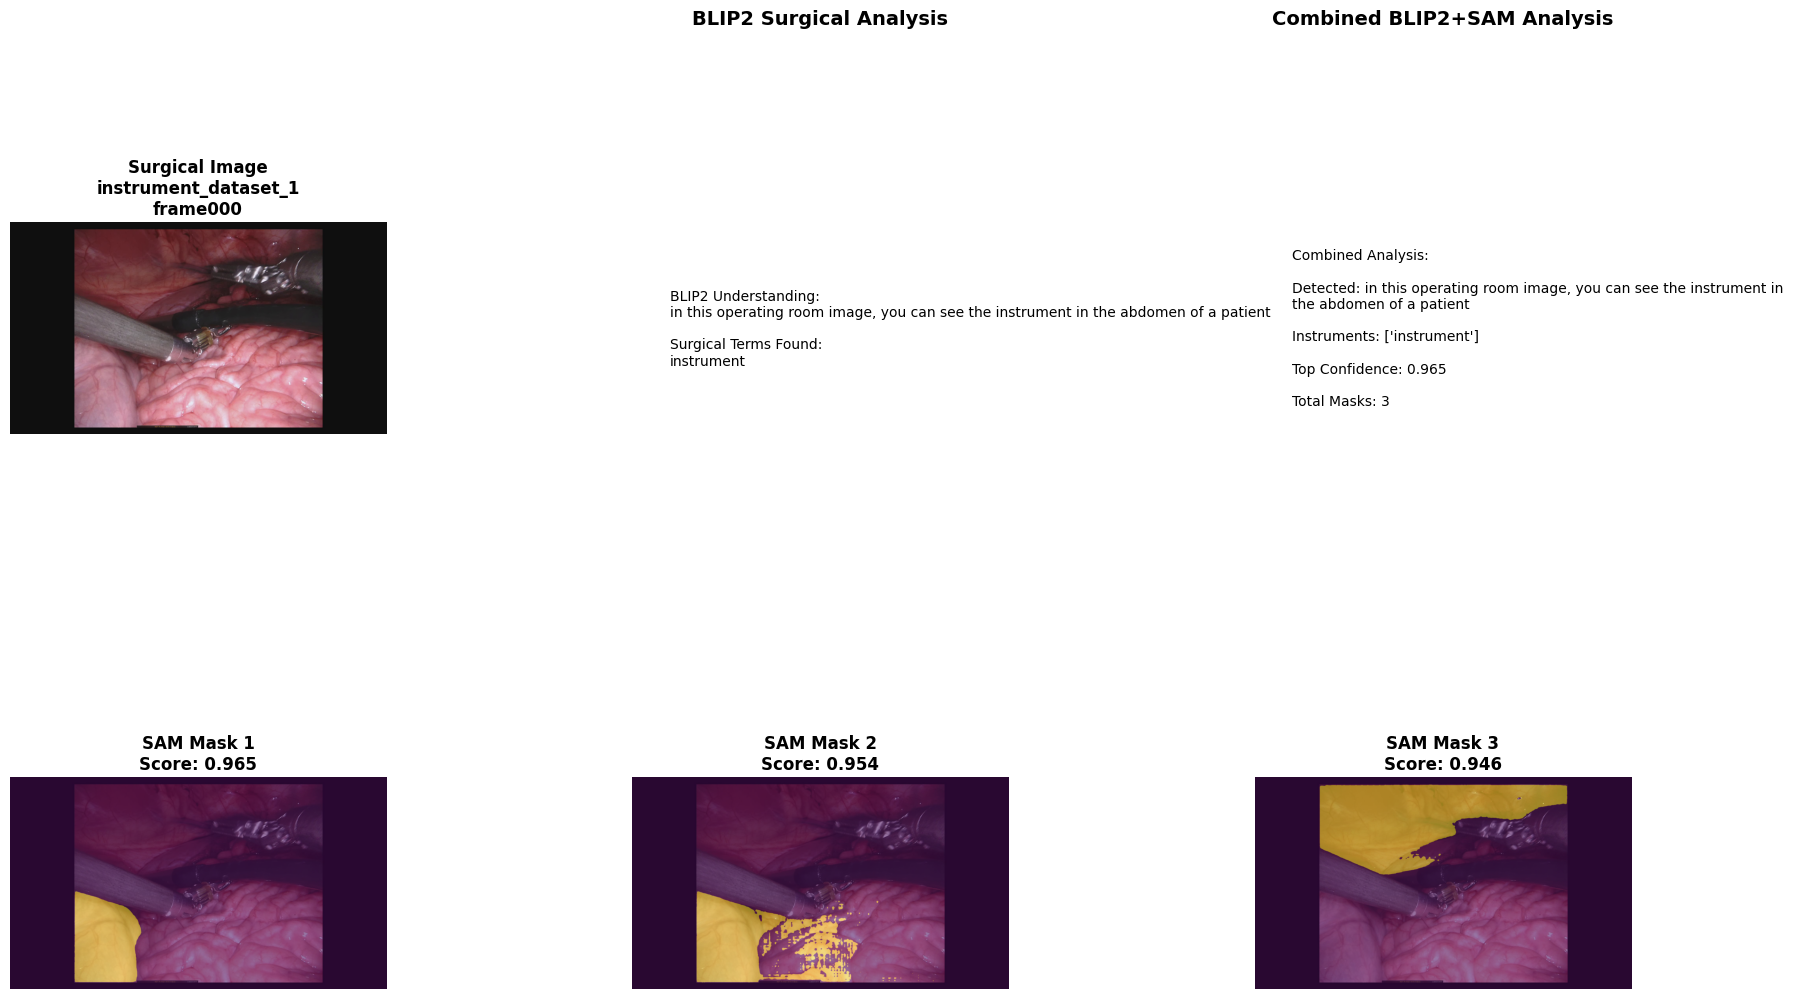


📊 Detailed Results for instrument_dataset_1 - frame000:
   🔍 BLIP2 Terms: ['instrument']
   ✂️ SAM Masks: 3
   🎯 Confidence: 0.965
   📋 Understanding: in this operating room image, you can see the instrument in the abdomen of a patient...
✅ Successfully processed image 1

📷 Processing Image 2: instrument_dataset_1 - frame001
------------------------------------------------------------
🔬 Processing surgical image with BLIP2: instrument_dataset_1 - frame001
  📝 BLIP2 Analysis...
    'a medical image of' → a medical image of the inside of the stomach

    'this surgical image shows' → this surgical image shows the inside of a patient's stomach

    'the surgical instruments are' → the surgical instruments are being used to open up the stomach

    'in this operating room image' → in this operating room image, you can see the endoscope in the abdomen of a
    'the surgical procedure involves' → the surgical procedure involves the removal of a tumor from the stomach

  ✂️ SAM Segmentation.

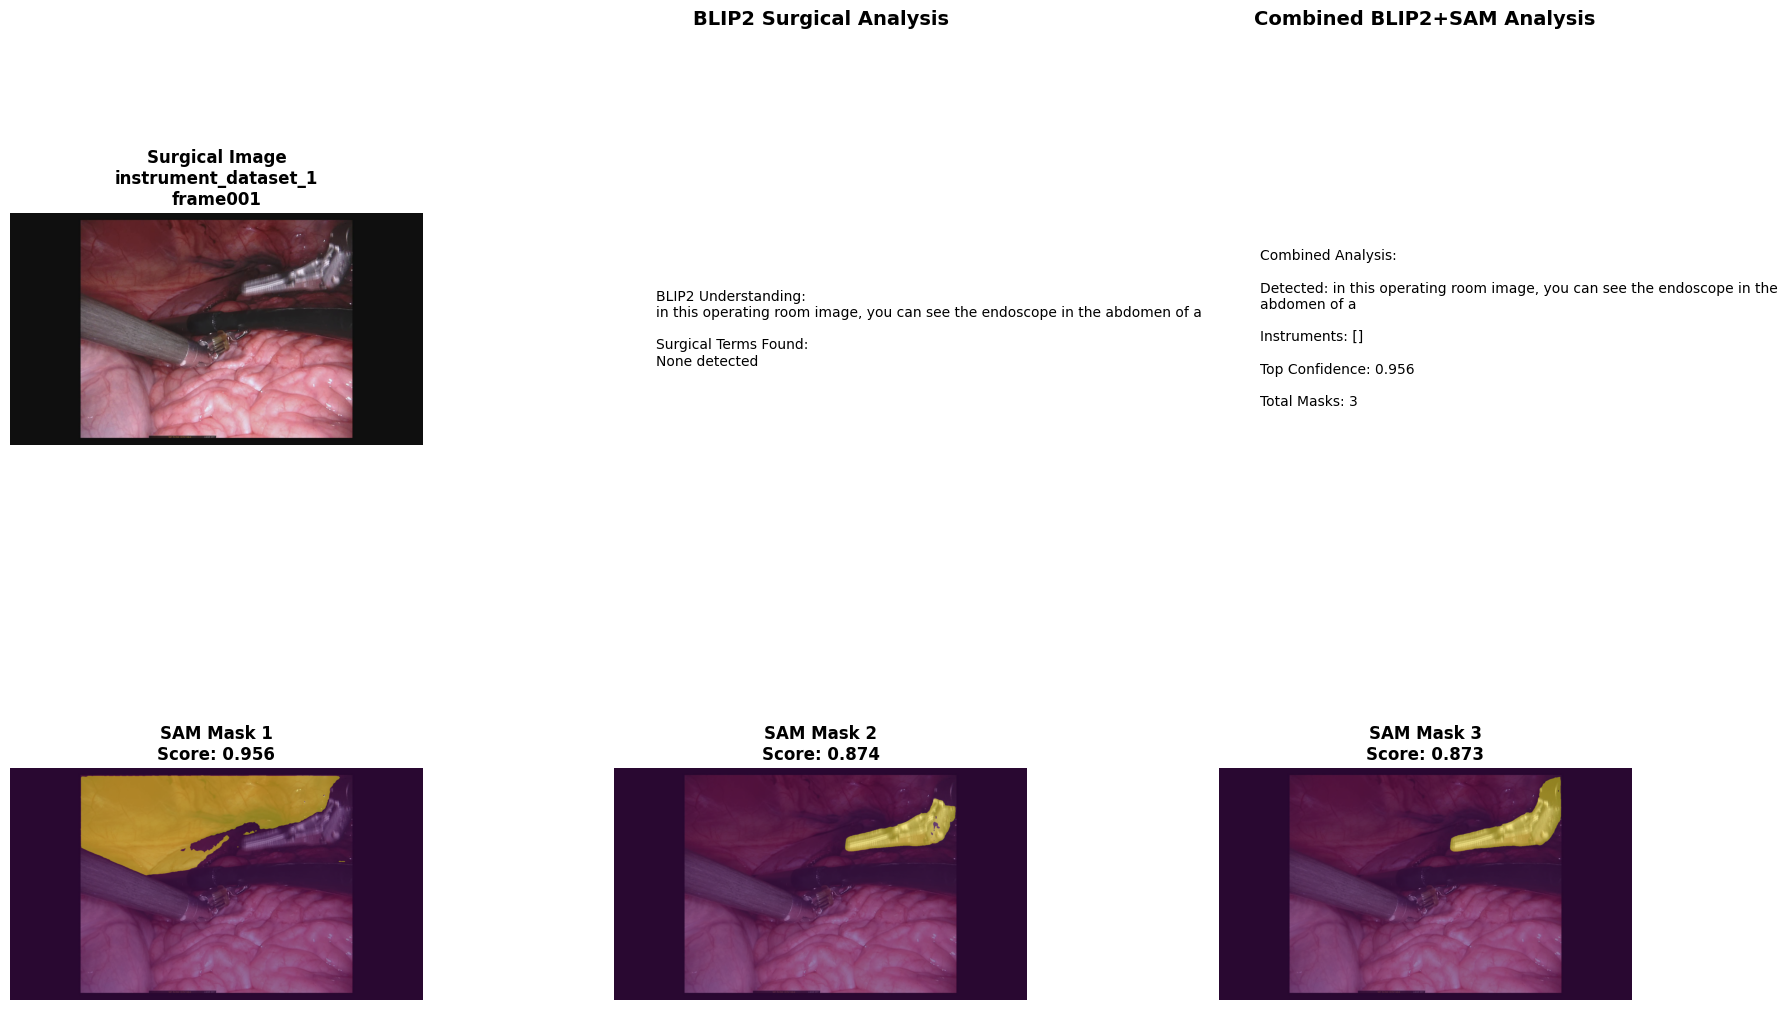


📊 Detailed Results for instrument_dataset_1 - frame001:
   🔍 BLIP2 Terms: []
   ✂️ SAM Masks: 3
   🎯 Confidence: 0.956
   📋 Understanding: in this operating room image, you can see the endoscope in the abdomen of a...
✅ Successfully processed image 2

📷 Processing Image 3: instrument_dataset_1 - frame002
------------------------------------------------------------
🔬 Processing surgical image with BLIP2: instrument_dataset_1 - frame002
  📝 BLIP2 Analysis...
    'a medical image of' → a medical image of the inside of the stomach

    'this surgical image shows' → this surgical image shows the inside of a patient's stomach

    'the surgical instruments are' → the surgical instruments are being used to open up the stomach

    'in this operating room image' → in this operating room image, you can see the instrument being used to remove a tumor
    'the surgical procedure involves' → the surgical procedure involves the removal of an object from inside the stomach

  ✂️ SAM Segmentation...

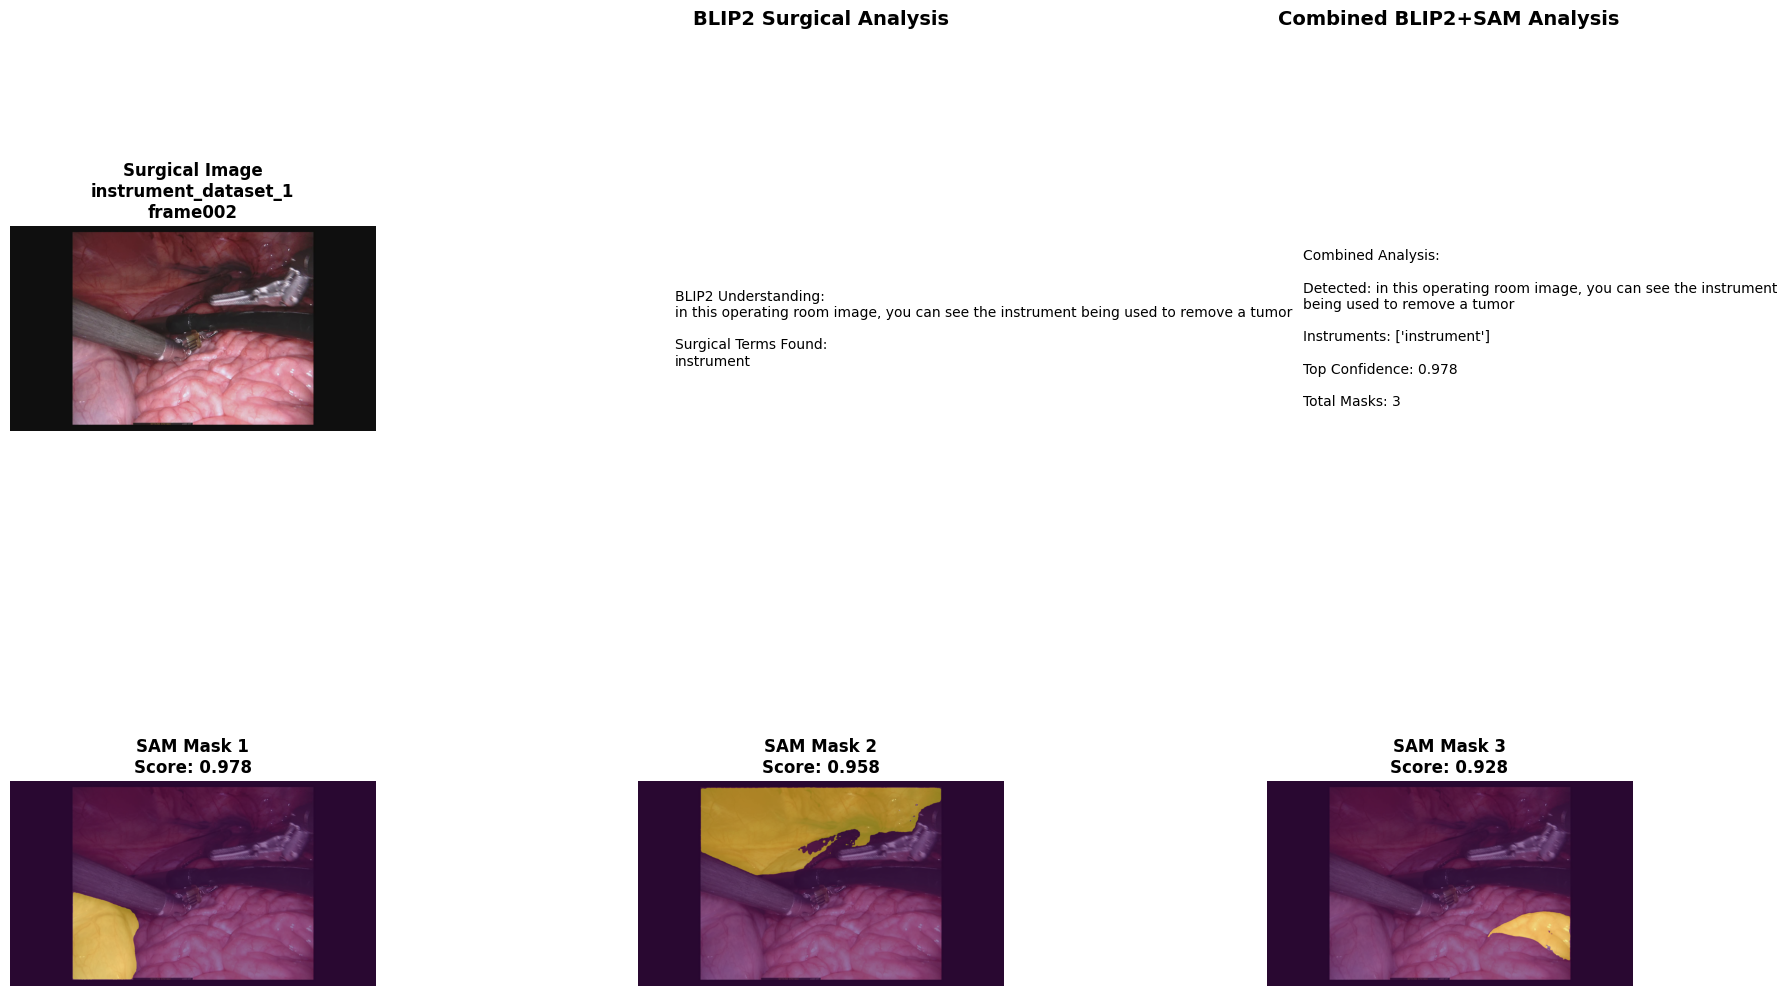


📊 Detailed Results for instrument_dataset_1 - frame002:
   🔍 BLIP2 Terms: ['instrument']
   ✂️ SAM Masks: 3
   🎯 Confidence: 0.978
   📋 Understanding: in this operating room image, you can see the instrument being used to remove a tumor...
✅ Successfully processed image 3

📷 Processing Image 4: instrument_dataset_2 - frame000
------------------------------------------------------------
🔬 Processing surgical image with BLIP2: instrument_dataset_2 - frame000
  📝 BLIP2 Analysis...
    'a medical image of' → a medical image of the inside of a person's mouth

    'this surgical image shows' → this surgical image shows the inside of a person's mouth

    'the surgical instruments are' → the surgical instruments are being used to remove an object from the inside of the mouth

    'in this operating room image' → in this operating room image, a surgeon is holding a pair of scissors

    'the surgical procedure involves' → the surgical procedure involves the removal of tissue from the inside o

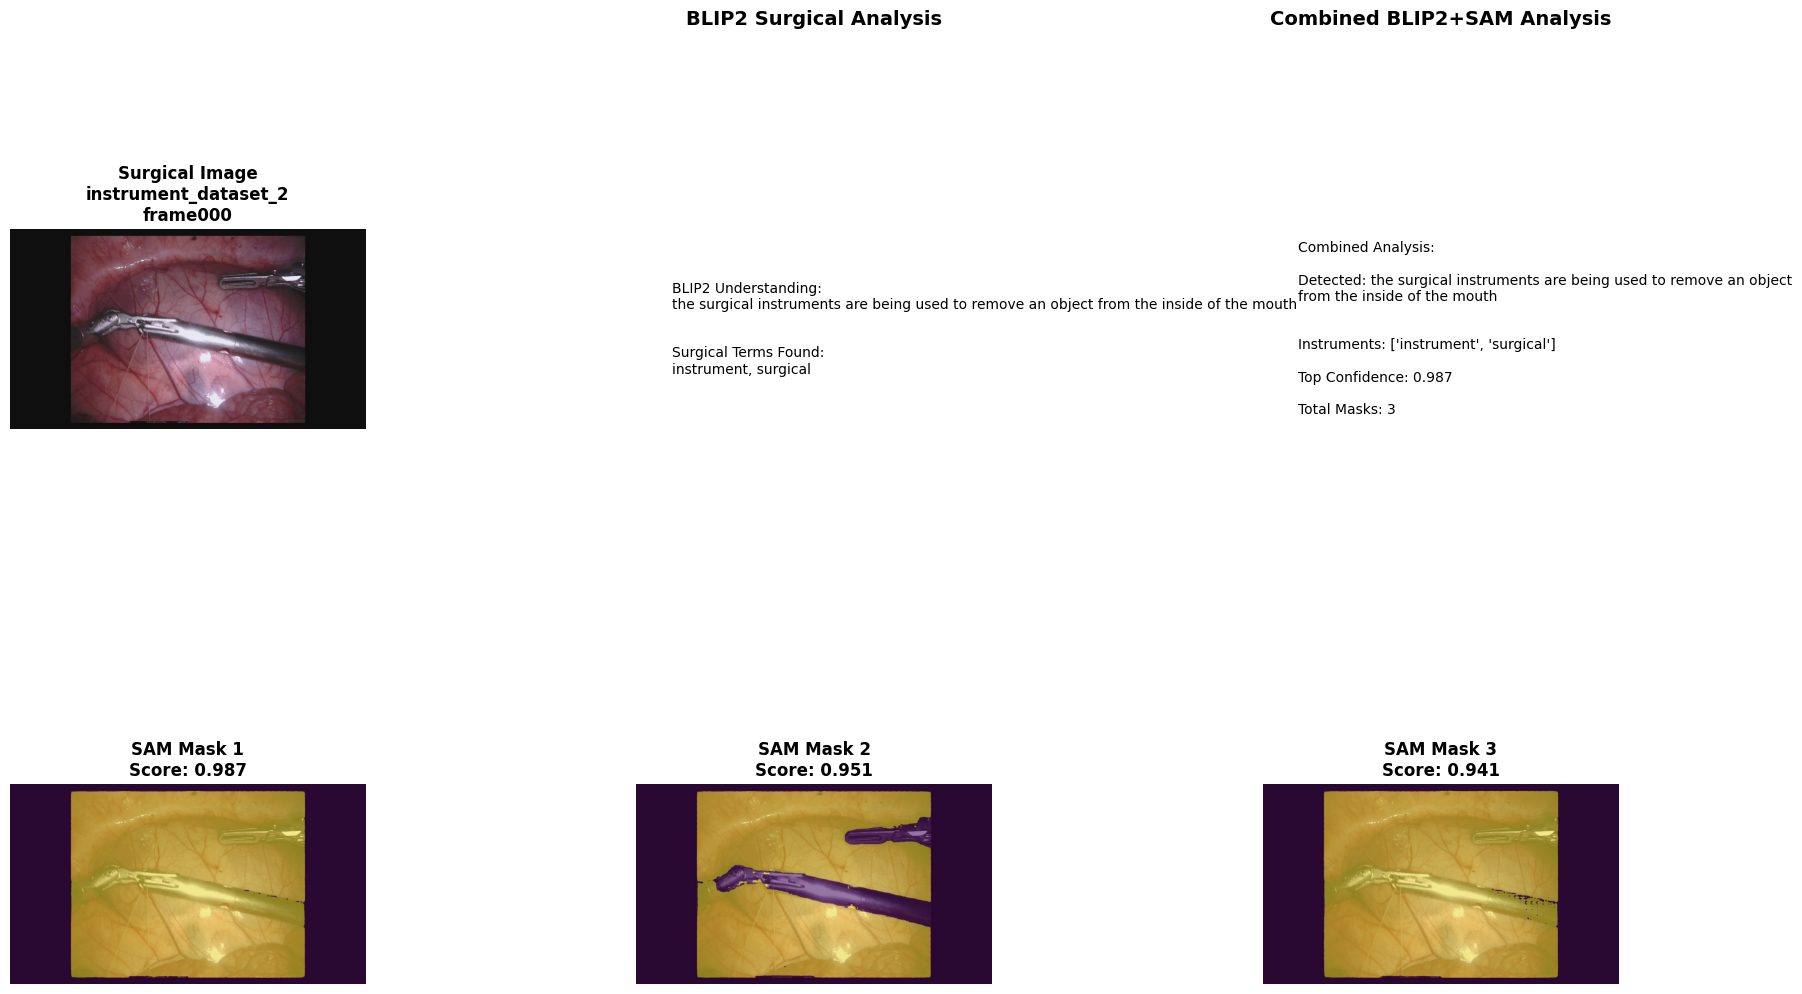


📊 Detailed Results for instrument_dataset_2 - frame000:
   🔍 BLIP2 Terms: ['instrument', 'surgical']
   ✂️ SAM Masks: 3
   🎯 Confidence: 0.987
   📋 Understanding: the surgical instruments are being used to remove an object from the inside of the mouth
...
✅ Successfully processed image 4

2️⃣ COMPREHENSIVE EVALUATION WITH METRICS
----------------------------------------
🔬 Comprehensive SAM+BLIP2 Performance Evaluation

📷 Evaluating Image 1: instrument_dataset_1 - frame000
🔬 Processing surgical image with BLIP2: instrument_dataset_1 - frame000
  📝 BLIP2 Analysis...
    'a medical image of' → a medical image of the inside of the stomach

    'this surgical image shows' → this surgical image shows the inside of a patient's stomach

    'the surgical instruments are' → the surgical instruments are in the stomach of a patient

    'in this operating room image' → in this operating room image, you can see the instrument in the abdomen of a patient
    'the surgical procedure involves' → the

({'segmentation': [{'dice_score': np.float64(0.18381128351212073),
    'iou_score': np.float64(0.10120714980961475),
    'pixel_accuracy': np.float64(0.4384577546296296),
    'precision': np.float64(1.0),
    'recall': np.float64(0.10120714980961475),
    'specificity': np.float64(1.0),
    'f1_score': np.float64(0.18381128351212073),
    'hausdorff_distance': 1173.6473064766944},
   {'dice_score': np.float64(0.44614785759199926),
    'iou_score': np.float64(0.2871237522642309),
    'pixel_accuracy': np.float64(0.5539882330246914),
    'precision': np.float64(1.0),
    'recall': np.float64(0.2871237522642309),
    'specificity': np.float64(1.0),
    'f1_score': np.float64(0.44614785759199926),
    'hausdorff_distance': 682.0975003619351},
   {'dice_score': np.float64(0.18922409506239765),
    'iou_score': np.float64(0.10449890267836215),
    'pixel_accuracy': np.float64(0.4417399691358025),
    'precision': np.float64(1.0),
    'recall': np.float64(0.10449890267836215),
    'specificit

In [ ]:
print("\n" + "=" * 80)
print("🎯 SAM + BLIP2 SURGICAL SEGMENTATION PIPELINE - READY TO EXECUTE!")
print("=" * 80)

print(f"\n📋 System Status:")
print(f"   ✅ SAM loaded and ready")
print(f"   ✅ BLIP2 loaded and ready")
print(f"   ✅ Surgical data: {len(surgical_data)} images")
print(f"   ✅ All functions defined")
print(f"   ✅ Metrics framework ready")

print(f"\n🚀 Ready to execute! Choose your option:")
print(f"   1. quick_test_single_image()           - Test on one image")
print(f"   2. batch_sam_blip2_analysis()          - Process multiple images")
print(f"   3. run_complete_sam_blip2_evaluation() - Full evaluation pipeline")

print(f"\n💡 Recommended: Start with option 1 for quick testing!")

# Uncomment the line below to run automatic execution:
run_complete_sam_blip2_evaluation()